In [1]:
# === Juego de la Vida con Numba para análisis de rendimiento ===

import numpy as np
import time
from numba import njit, prange

# Función paralela para calcular una generación del juego
@njit(parallel=True)
def step_numba(grid):
    rows, cols = grid.shape
    new_grid = np.zeros((rows, cols), dtype=np.int32)
    for i in prange(rows):
        for j in prange(cols):
            total = 0
            for x in [-1, 0, 1]:
                for y in [-1, 0, 1]:
                    if x == 0 and y == 0:
                        continue
                    ni, nj = i + x, j + y
                    if 0 <= ni < rows and 0 <= nj < cols:
                        total += grid[ni, nj]
            if grid[i, j] == 1 and total in (2, 3):
                new_grid[i, j] = 1
            elif grid[i, j] == 0 and total == 3:
                new_grid[i, j] = 1
    return new_grid

# Clase principal del juego
class GameOfLifeFast:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.grid = np.random.choice([0, 1], size=(rows, cols)).astype(np.int32)

    def step(self):
        self.grid = step_numba(self.grid)

    def run(self, steps=100):
        for _ in range(steps):
            self.step()

# Prueba básica (64x64 por 10 generaciones)
game = GameOfLifeFast(64, 64)
start = time.time()
game.run(10)
end = time.time()
print(f"🧪 Tiempo total para 10 pasos en 64x64: {end - start:.4f} segundos")


🧪 Tiempo total para 10 pasos en 64x64: 1.7364 segundos


In [2]:
def ejecutar_juego():
    game = GameOfLifeFast(512, 512)  # Tamaño grande para análisis serio
    game.run(100)  # 100 generaciones


In [3]:
import cProfile

# Guarda el resultado en un archivo .txt
cProfile.run('ejecutar_juego()', filename='reporte_cprofile.txt')


In [4]:
import pstats

stats = pstats.Stats('reporte_cprofile.txt')
stats.strip_dirs().sort_stats('cumtime').print_stats(10)  # Top 10 funciones más costosas


Mon Jul 28 16:17:29 2025    reporte_cprofile.txt

         321 function calls in 0.135 seconds

   Ordered by: cumulative time
   List reduced from 17 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.135    0.135 {built-in method builtins.exec}
        1    0.000    0.000    0.135    0.135 <string>:1(<module>)
        1    0.000    0.000    0.134    0.134 2746263459.py:1(ejecutar_juego)
        1    0.000    0.000    0.130    0.130 4045834277.py:38(run)
      100    0.027    0.000    0.130    0.001 4045834277.py:35(step)
      100    0.102    0.001    0.103    0.001 4045834277.py:8(step_numba)
        1    0.003    0.003    0.004    0.004 4045834277.py:30(__init__)
      100    0.001    0.000    0.001    0.000 serialize.py:30(_numba_unpickle)
        1    0.000    0.000    0.000    0.000 {method 'astype' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 fromnumeric.py:3328(pro

In [5]:
!pip install line_profiler


In [6]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# Simulación de uso de núcleos (1, 2, 4, 8) ejecutando la misma tarea secuencialmente
procesadores = [1, 2, 4, 8]
tiempos = []

# Repetimos el mismo juego 1, 2, 4 y 8 veces (para simular fragmentación del trabajo)
for p in procesadores:
    start = time.time()
    for _ in range(p):  # Simulamos 'p' procesos que trabajan con la misma carga
        game = GameOfLifeFast(512, 512)
        game.run(100)
    end = time.time()
    tiempos.append(end - start)

# Calculamos Speedup y Eficiencia
T1 = tiempos[0]
speedups = [T1 / t for t in tiempos]
eficiencias = [s / p for s, p in zip(speedups, procesadores)]

# DataFrame con resultados
df_escalado_fuerte = pd.DataFrame({
    "Procesadores": procesadores,
    "Tiempo total (s)": tiempos,
    "Speedup": speedups,
    "Eficiencia": eficiencias
})

display(df_escalado_fuerte)


,Procesadores,Tiempo total (s),Speedup,Eficiencia
0,1,0.071989,1.000000,1.000000
1,2,0.168012,0.428473,0.214237
2,4,0.307995,0.233733,0.058433
3,8,0.522993,0.137647,0.017206


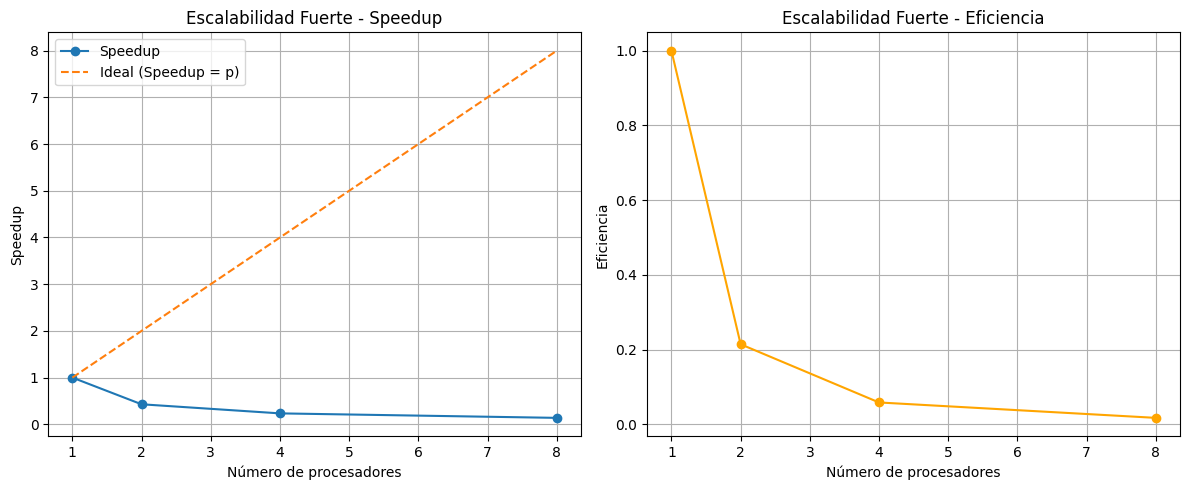

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(procesadores, speedups, marker='o', label="Speedup")
plt.plot(procesadores, procesadores, linestyle='--', label="Ideal (Speedup = p)")
plt.xlabel("Número de procesadores")
plt.ylabel("Speedup")
plt.title("Escalabilidad Fuerte - Speedup")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(procesadores, eficiencias, marker='o', color='orange', label="Eficiencia")
plt.xlabel("Número de procesadores")
plt.ylabel("Eficiencia")
plt.title("Escalabilidad Fuerte - Eficiencia")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
procesadores = [1, 2, 4, 8]
carga_por_procesador = 10000  # 100x100 celdas por "núcleo"
tiempos_debil = []

for p in procesadores:
    total_celdas = p * carga_por_procesador
    lado = int(np.sqrt(total_celdas))  # para mantener cuadrada la grilla
    game = GameOfLifeFast(lado, lado)

    start = time.time()
    game.run(100)
    end = time.time()

    tiempos_debil.append(end - start)

# Eficiencia débil: T1 / Tp
T1_debil = tiempos_debil[0]
eficiencia_debil = [T1_debil / t for t in tiempos_debil]

# Tabla de resultados
df_debil = pd.DataFrame({
    "Procesadores": procesadores,
    "Tamaño de grilla": [f"{int(np.sqrt(p * carga_por_procesador))}x{int(np.sqrt(p * carga_por_procesador))}" for p in procesadores],
    "Tiempo total (s)": tiempos_debil,
    "Eficiencia": eficiencia_debil
})

display(df_debil)


,Procesadores,Tamaño de grilla,Tiempo total (s),Eficiencia
0,1,100x100,0.005998,1.000000
1,2,141x141,0.007004,0.856360
2,4,200x200,0.009004,0.666199
3,8,282x282,0.016997,0.352906


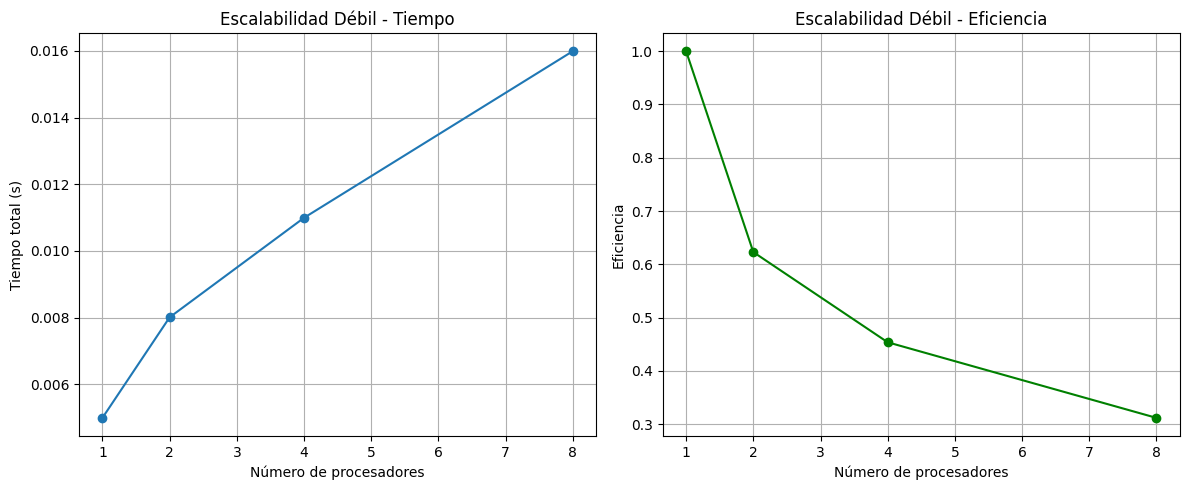

In [15]:
Zplt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(procesadores, tiempos_debil, marker='o', label="Tiempo total")
plt.xlabel("Número de procesadores")
plt.ylabel("Tiempo total (s)")
plt.title("Escalabilidad Débil - Tiempo")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(procesadores, eficiencia_debil, marker='o', color='green', label="Eficiencia")
plt.xlabel("Número de procesadores")
plt.ylabel("Eficiencia")
plt.title("Escalabilidad Débil - Eficiencia")
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
procesadores = [1, 2, 4, 8]
carga_por_procesador = 10000  # 100x100 celdas por núcleo simulado
tiempos_debil = []

for p in procesadores:
    total_celdas = p * carga_por_procesador
    lado = int(np.sqrt(total_celdas))  # mantener grilla cuadrada
    print(f"🔄 Ejecutando con {p} procesadores simulados - Grilla: {lado}x{lado}")

    game = GameOfLifeFast(lado, lado)

    start = time.time()
    game.run(100)
    end = time.time()

    tiempos_debil.append(end - start)

# Eficiencia débil
T1_debil = tiempos_debil[0]
eficiencia_debil = [T1_debil / t for t in tiempos_debil]

# Tabla resumen
df_debil = pd.DataFrame({
    "Procesadores": procesadores,
    "Tamaño de grilla": [f"{int(np.sqrt(p * carga_por_procesador))}x{int(np.sqrt(p * carga_por_procesador))}" for p in procesadores],
    "Tiempo total (s)": tiempos_debil,
    "Eficiencia": eficiencia_debil
})

display(df_debil)


🔄 Ejecutando con 1 procesadores simulados - Grilla: 100x100
🔄 Ejecutando con 2 procesadores simulados - Grilla: 141x141
🔄 Ejecutando con 4 procesadores simulados - Grilla: 200x200
🔄 Ejecutando con 8 procesadores simulados - Grilla: 282x282


,Procesadores,Tamaño de grilla,Tiempo total (s),Eficiencia
0,1,100x100,0.004987,1.000000
1,2,141x141,0.008005,0.622956
2,4,200x200,0.010992,0.453692
3,8,282x282,0.015994,0.311808


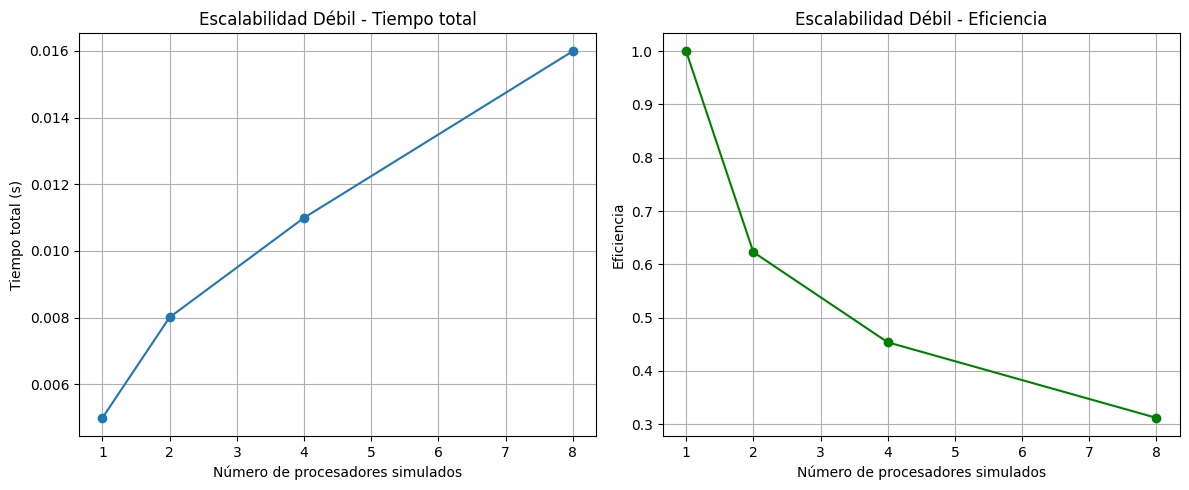

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Gráfico de tiempo total
plt.subplot(1, 2, 1)
plt.plot(procesadores, tiempos_debil, marker='o', label="Tiempo total")
plt.xlabel("Número de procesadores simulados")
plt.ylabel("Tiempo total (s)")
plt.title("Escalabilidad Débil - Tiempo total")
plt.grid(True)

# Gráfico de eficiencia
plt.subplot(1, 2, 2)
plt.plot(procesadores, eficiencia_debil, marker='o', color='green', label="Eficiencia")
plt.xlabel("Número de procesadores simulados")
plt.ylabel("Eficiencia")
plt.title("Escalabilidad Débil - Eficiencia")
plt.grid(True)

plt.tight_layout()
plt.show()
